In [2]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tensorflow.keras.layers import Dense , Dropout
from scikeras.wrappers import KerasRegressor 
from tensorflow.keras.callbacks import EarlyStopping
import time
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV


In [6]:
#data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/TPath_300_finish_data.pkl')
data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish_D2_I7000_F9000/TPath_500_finish_data_D2.pkl')

data

,X-Koordinate,Y-Koordinate,Zeitpunkt,Strom,Kraft,Temperatur
0,0.0000,-0.00200,500,7000,9000,669.05
1,0.0000,-0.00198,500,7000,9000,682.81
2,0.0000,-0.00196,500,7000,9000,696.80
3,0.0000,-0.00194,500,7000,9000,710.67
4,0.0000,-0.00192,500,7000,9000,724.42
...,...,...,...,...,...,...
25321,0.0025,0.00192,500,7000,9000,584.84
25322,0.0025,0.00194,500,7000,9000,581.64
25323,0.0025,0.00196,500,7000,9000,578.47
25324,0.0025,0.00198,500,7000,9000,575.32


In [3]:
df = data.drop(data.columns[2:5], axis = 1)
df

,X-Koordinate,Y-Koordinate,Temperatur
0,0.0000,-0.00200,532.25
1,0.0000,-0.00198,540.69
2,0.0000,-0.00196,549.09
3,0.0000,-0.00194,557.38
4,0.0000,-0.00192,565.57
...,...,...,...
25321,0.0025,0.00192,486.58
25322,0.0025,0.00194,481.54
25323,0.0025,0.00196,477.19
25324,0.0025,0.00198,473.54


In [4]:
df1 = df.sample(frac=1, random_state=42)  # Hier wird 42 als Random State verwendet, um die Ergebnisse reproduzierbar zu machen

print(df1)
df_reset = df1.reset_index(drop=True)
df_reset

       X-Koordinate  Y-Koordinate  Temperatur
5099        0.00050      -0.00052      896.41
12799       0.00126       0.00072      836.73
15071       0.00148       0.00194      488.76
24620       0.00244      -0.00004      747.54
11071       0.00110      -0.00168      661.61
...             ...           ...         ...
21575       0.00214      -0.00064      784.07
5390        0.00052       0.00128      728.92
860         0.00008      -0.00088      863.65
15795       0.00156       0.00034      844.40
23654       0.00234       0.00074      753.46

[25326 rows x 3 columns]


,X-Koordinate,Y-Koordinate,Temperatur
0,0.00050,-0.00052,896.41
1,0.00126,0.00072,836.73
2,0.00148,0.00194,488.76
3,0.00244,-0.00004,747.54
4,0.00110,-0.00168,661.61
...,...,...,...
25321,0.00214,-0.00064,784.07
25322,0.00052,0.00128,728.92
25323,0.00008,-0.00088,863.65
25324,0.00156,0.00034,844.40


In [5]:
label = df_reset["Temperatur"]
# Korrektur: Verwenden Sie den Spaltennamen direkt, ohne Indexierung der columns-Eigenschaft
df1 = df_reset.drop("Temperatur", axis=1)
X = df1
y = label


In [6]:
X

,X-Koordinate,Y-Koordinate
0,0.00050,-0.00052
1,0.00126,0.00072
2,0.00148,0.00194
3,0.00244,-0.00004
4,0.00110,-0.00168
...,...,...
25321,0.00214,-0.00064
25322,0.00052,0.00128
25323,0.00008,-0.00088
25324,0.00156,0.00034


In [7]:
y

0        896.41
1        836.73
2        488.76
3        747.54
4        661.61
          ...  
25321    784.07
25322    728.92
25323    863.65
25324    844.40
25325    753.46
Name: Temperatur, Length: 25326, dtype: float64

In [8]:
 # train_df enthält 80% der Daten, test_df enthält 20% der Daten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [9]:
# Initialisiere einen MinMaxScaler für die Features
scaler_features = MinMaxScaler()
scaler_features2 = MinMaxScaler()
# Skaliere X_train und X_test
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)  # Nutze unterschiedliche Skalierungsparameter

# Initialisiere einen SEPARATEN MinMaxScaler für das Ziel, wenn nötig
scaler_target = MinMaxScaler()


# Skaliere y_train und y_test. Beachte, dass y_train.reshape(-1, 1) verwendet wird, da MinMaxScaler 
# erwartet, dass die Eingaben als 2D-Arrays kommen, und Ziele normalerweise als 1D-Arrays vorliegen.
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))


In [10]:
X_train_scaled

array([[1.   , 0.15 ],
       [0.984, 0.49 ],
       [0.224, 0.905],
       ...,
       [0.04 , 0.585],
       [0.976, 0.815],
       [0.744, 0.785]])

# Netzwerkarchitektur

In [20]:
# Netzwerkarchitektur
model = Sequential([

    Dense(280, activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

    Dense(168, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(296, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(312, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

    Dense(104, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

    Dense(152, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(216, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

    Dense(1 , activation = 'linear')
])

# Optimierer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Modell kompilieren (Verwendung von mean_squared_error als Verlustfunktion für Regression)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])  # Metriken für Regression: Mean Absolute Error und Mean Squared Error

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Trainingsparameter
batch_size = 50
epochs = 200

# Modell trainieren (Annahme: X_train, y_train, X_val, y_val sind vordefiniert)
history = model.fit(X_train_scaled, y_train_scaled,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/200
325/325 [==============================] - 2s 3ms/step - loss: 0.2521 - mae: 0.1335 - val_loss: 0.1698 - val_mae: 0.0378
Epoch 2/200
325/325 [==============================] - 1s 3ms/step - loss: 0.1599 - mae: 0.0364 - val_loss: 0.1474 - val_mae: 0.0136
Epoch 3/200
325/325 [==============================] - 1s 3ms/step - loss: 0.1397 - mae: 0.0161 - val_loss: 0.1317 - val_mae: 0.0115
Epoch 4/200
325/325 [==============================] - 1s 2ms/step - loss: 0.1265 - mae: 0.0213 - val_loss: 0.1186 - val_mae: 0.0110
Epoch 5/200
325/325 [==============================] - 1s 2ms/step - loss: 0.1131 - mae: 0.0132 - val_loss: 0.1076 - val_mae: 0.0186
Epoch 6/200
325/325 [==============================] - 1s 3ms/step - loss: 0.1025 - mae: 0.0173 - val_loss: 0.0967 - val_mae: 0.0081
Epoch 7/200
325/325 [==============================] - 1s 3ms/step - loss: 0.0921 - mae: 0.0107 - val_loss: 0.0873 - val_mae: 0.0092
Epoch 8/200
325/325 [==============================] - 1s 3ms/step - 

In [21]:
results = model.evaluate(X_test_scaled, y_test_scaled, verbose=2)
results

159/159 - 0s - loss: 0.0013 - mae: 0.0076 - 167ms/epoch - 1ms/step


[0.001294836401939392, 0.007613654714077711]

In [22]:
scaled_predicted_values = model.predict(X_test_scaled, verbose = 0)

# Führen Sie die Rücktransformation der skalierten Werte durch
original_predicted_values = scaler_target.inverse_transform(scaled_predicted_values)
original_actual_values = scaler_target.inverse_transform(y_test_scaled)  # y_test sind die skalierten tatsächlichen Werte
print(f' Bsp. Predicted: {original_predicted_values[100]} Actual: {original_actual_values[100]} ')

def calculate_mae(list1, list2):
    # Stelle sicher, dass beide Listen die gleiche Länge haben
    if len(list1) != len(list2):
        raise ValueError("Listen müssen die gleiche Länge haben")

    # Berechne die absolute Differenz zwischen den Elementen der Listen
    differences = [abs(x - y) for x, y in zip(list1, list2)]

    # Berechne den Durchschnitt der absoluten Differenzen
    mae = sum(differences) / len(differences)

    return mae

# Beispiel
list1 = original_predicted_values
list2 = original_actual_values

mae = calculate_mae(list1, list2)
print(f"Durchschnittliche Abweichung (MAE): {mae}")


 Bsp. Predicted: [780.1753] Actual: [783.15] 
Durchschnittliche Abweichung (MAE): [3.37665323]


In [ ]:
def calculate_r_squared(predicted, actual):
    # Berechnung des Mittelwerts der tatsächlichen Werte
    mean_actual = sum(actual) / len(actual)
    
    # Berechnung der totalen Summe der Quadrate (SST)
    sst = sum((x - mean_actual) ** 2 for x in actual)
    
    # Berechnung der Summe der Quadrate der Residuen (SSE)
    sse = sum((actual[i] - predicted[i]) ** 2 for i in range(len(actual)))
    
    # Berechnung des R^2-Wertes
    r_squared = 1 - (sse / sst)
    
    return r_squared

# Berechnung von R^2 mit den bereitgestellten Listen
r_squared = calculate_r_squared(list1, list2)

print(f"R^2: {r_squared}")

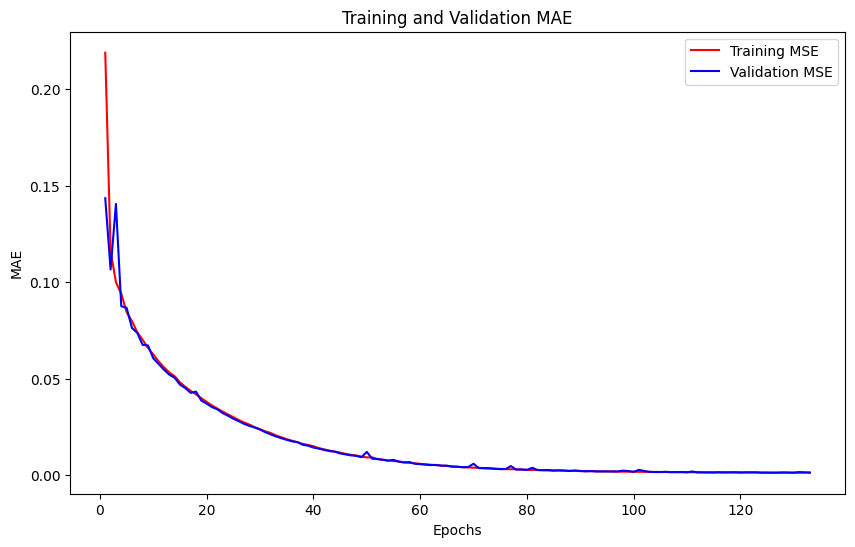

In [15]:
mae = history.history['loss']
val_mae = history.history['val_loss']

epochs = range(1, len(mae) + 1)

# MAE Diagramm
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, 'r', label='Training MSE')
plt.plot(epochs, val_mae, 'b', label='Validation MSE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [16]:
df_result = pd.DataFrame({'Echt': [val[0] for val in list1], 'Vorhergesagt': [val[0] for val in list2]})
df_result['X-Koordinate'] = X_test_scaled[:, 0]
df_result['Y-Koordinate'] = X_test_scaled[:, 1]

df_result['Differenz'] = df_result['Echt'] - df_result['Vorhergesagt']
df_result['Differenz'].sort_values()
sorted_df = df_result.sort_values(by= 'Differenz')
Anzahl_Punkte = (sorted_df['Differenz'] > -10).sum()
print("Anzahl der Werte die kleiner sind:", Anzahl_Punkte)

sorted_df

Anzahl der Werte die kleiner sind: 5052


,Echt,Vorhergesagt,X-Koordinate,Y-Koordinate,Differenz
4855,597.932434,628.54,1.000,0.940,-30.607566
2316,614.748596,642.22,0.992,0.930,-27.471404
4353,621.843201,642.43,0.976,0.925,-20.586799
2187,639.355408,657.61,0.976,0.915,-18.254592
731,612.223328,629.54,0.968,0.930,-17.316672
...,...,...,...,...,...
1631,584.326294,550.60,0.888,0.000,33.726294
3047,522.104126,487.23,0.952,0.980,34.874126
3964,522.949219,487.60,0.960,0.980,35.349219
3122,517.484802,481.85,0.992,0.985,35.634802


# GridSearch

In [51]:
# def build_model(learning_rate=0.001, activation='relu', regularization=0.0001, dropout_rate=0.0):
#     model = Sequential()
#     model.add(Dense(264, activation=activation, input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(168, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(88, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(264, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(200, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     # model.add(Dense(192, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     # model.add(Dropout(dropout_rate))
#     # 
#     # model.add(Dense(32, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     # model.add(Dropout(dropout_rate))
#     # 
#     # model.add(Dense(448, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     # model.add(Dropout(dropout_rate))    
#     # 
#     # model.add(Dense(64, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     # model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(1, activation='linear'))
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
#     return model
# 
# # Verwenden Sie eine Funktion, um das Modell zu instanziieren, für scikit-learn Wrapper
# model = KerasRegressor(model=build_model, verbose=2)
# 
# # Anpassung der Parameter im param_grid
# param_grid = {
#     'model__learning_rate': [0.01, 0.001, 0.0001],
#     'model__regularization': [0.001, 0.0001],
#     'fit__batch_size': [50, 100, 150, 200],
#     'fit__epochs': [50],
#     'model__dropout_rate' : [0.0, 0.1, 0.2]
# }
# 
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
# # Hinweis: Stellen Sie sicher, dass Ihre Daten (X_train_scaled, y_train_scaled) korrekt definiert sind
# grid_result = grid_search.fit(X_train_scaled, y_train_scaled)
# # Beste Parameter und Score ausgeben
# print("Beste Parameter:", grid_search.best_params_)
# print("Beste Genauigkeit:", grid_search.best_score_)
# 
# with open("Gridsearch_D2_1.txt", "w") as f:
#     f.write(f"Beste Parameter: {grid_search.best_params_}\n")
#     f.write(f"Beste Genauigkeit: {grid_search.best_score_}")


Fitting 3 folds for each of 72 candidates, totalling 216 fits


KeyboardInterrupt: 

# Random Search Architektur

In [49]:
# # Funktion zum Erstellen des Modells
# def build_model(hp):
#     model = Sequential()
#     model.add(Dense(hp.Int('input_units', min_value=8, max_value=328, step=16), input_shape=(2,), activation='relu'))
#     for i in range(hp.Int('n_layers', 1, 10)):
#         model.add(Dense(hp.Int(f'units_{i}', min_value=8, max_value=328, step=16), activation='relu'))
#     model.add(Dense(1, activation='linear'))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model
# 
# # Durchführung der Random Search dreimal
# for run in range(1, 4):
#     # Anpassen des Verzeichnisses und des Projektnamens für jeden Durchlauf
#     directory = 'random_search'
#     project_name = f'random_search_D2_{run}'
#     
#     tuner = RandomSearch(
#         build_model,
#         objective='val_loss',
#         max_trials=100,
#         executions_per_trial=1,
#         directory=directory,
#         project_name=project_name
#     )
#     
#     # Durchführung des Random Search
#     tuner.search(X_train_scaled, y_train_scaled, epochs=200, verbose =0, batch_size=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
#     
#     # Abrufen und Speichern des besten Modells
#     best_model = tuner.get_best_models(num_models=1)[0]
#     model_path = os.path.join(directory, project_name, 'best_model.h5') 
#     best_model.save(model_path)
#     
# 
#     # Optional: Abrufen und Ausgeben der besten Hyperparameter
#     best_hyperparameters = tuner.get_best_hyperparameters()[0]
#     
#     # Konvertieren der Hyperparameter in ein DataFrame
#     df_hyperparameters = pd.DataFrame([best_hyperparameters.values])
#     # Speichern des DataFrame als CSV
#     df_hyperparameters.to_csv(f'random_search_D2_{run}.csv', index=False)
#     
#     print(f"Beste Hyperparameter für Lauf {run}: {best_hyperparameters.values}")

C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Beste Hyperparameter für Lauf 1: {'input_units': 264, 'n_layers': 4, 'units_0': 168, 'units_1': 88, 'units_2': 264, 'units_3': 200, 'units_4': 88, 'units_5': 280, 'units_6': 56, 'units_7': 184, 'units_8': 312, 'units_9': 264}
Beste Hyperparameter für Lauf 2: {'input_units': 136, 'n_layers': 10, 'units_0': 280, 'units_1': 168, 'units_2': 8, 'units_3': 136, 'units_4': 88, 'units_5': 248, 'units_6': 184, 'units_7': 232, 'units_8': 184, 'units_9': 296}
Beste Hyperparameter für Lauf 3: {'input_units': 328, 'n_layers': 5, 'units_0': 312, 'units_1': 168, 'units_2': 56, 'units_3': 168, 'units_4': 152, 'units_5': 248, 'units_6': 8, 'units_7': 248, 'units_8': 248, 'units_9': 280}


In [50]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 328)               984       
                                                                 
 dense_1 (Dense)             (None, 312)               102648    
                                                                 
 dense_2 (Dense)             (None, 168)               52584     
                                                                 
 dense_3 (Dense)             (None, 56)                9464      
                                                                 
 dense_4 (Dense)             (None, 168)               9576      
                                                                 
 dense_5 (Dense)             (None, 152)               25688     
                                                                 
 dense_6 (Dense)             (None, 1)                 1